# 🌤️ 3‑Day Weather Forecast Notebook

This Jupyter Notebook provides a full weather forecasting workflow — from city input to interactive and static visualizations.  
Key features:

- ✅ Fetch geographical coordinates for a city using geocoding  
- 🌍 Get 3‑day hourly weather forecast from a weather API  
- 📄 Display per‑day styled tables summarizing hourly forecast data  
- 📊 Show a static Plotly chart with multiple metrics (temperature, “feels like”, humidity) and day‑toggle buttons  
- 🎞️ Generate an animated hourly forecast plot to see weather evolution over time  
- 🗺️ Display a map (via Folium) showing current weather conditions at the city’s location  
- 💾 Export full forecast data and visual outputs: CSV, Excel, static HTML, interactive HTML, and map HTML  

In [2]:
!pip install requests pandas plotly geopy fuzzywuzzy openpyxl folium --quiet

## Imports

In [4]:
import os
import requests
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime
from geopy.geocoders import Nominatim
from IPython.display import display, Markdown
from fuzzywuzzy import process
import folium

## Function: weather_code_to_emoji

In [6]:
def weather_code_to_emoji(code: int) -> str:
    """
    Convert an Open-Meteo weather code into a corresponding emoji.

    Parameters:
        code (int): Weather code returned by the Open-Meteo API.

    Returns:
        str: Emoji that represents the given weather condition.
    """
    mapping = {
        0 : '☀️',  1 : '🌤️', 2 : '⛅',  3 : '☁️',
        45 : '🌫️', 48 : '🌫️',
        51 : '🌦️', 53 : '🌦️', 55 : '🌦️',
        56 : '🌨️', 57 : '🌨️',
        61 : '🌧️', 63 : '🌧️', 65 : '🌧️',
        66 : '❄️',  67 : '❄️',
        71 : '❄️',  73 : '❄️', 75 : '❄️', 77 : '❄️',
        80 : '🌦️', 81 : '🌦️', 82 : '🌧️',
        85 : '❄️',  86 : '❄️',
        95 : '⛈️',  96 : '⛈️', 99 : '⛈️'}

    return mapping.get(code, '🌈')

## Function: get_coordinates

In [8]:
def get_coordinates(city: str):
    """
    Get the latitude, longitude, and full address for a given city.

    Parameters:
        city (str): Name of the city.

    Returns:
        tuple: (latitude, longitude, full_address) or None if the city
               cannot be found.
    """
    geolocator = Nominatim(user_agent = "weather_portfolio_app")
    location = geolocator.geocode(city)

    if location is None:
        return None

    latitude = location.latitude
    longitude = location.longitude
    full_address = location.address

    return latitude, longitude, full_address

## Function: get_forecast

In [10]:
def get_forecast(lat: float, lon: float, days: int = 3) -> pd.DataFrame:
    """
    Fetch an hourly weather forecast for the given coordinates.

    Parameters:
        lat (float): Latitude.
        lon (float): Longitude.
        days (int): Number of days to fetch (default is 3).

    Returns:
        pd.DataFrame: Contains columns for time, temperature, humidity,
                      wind speed, precipitation, weather emoji, and date.
    """
    url = "https://api.open-meteo.com/v1/forecast"
    params = {"latitude" : lat,
            "longitude" : lon,
            "hourly" : "temperature_2m,apparent_temperature,relative_humidity_2m,weathercode,windspeed_10m,precipitation",
            "timezone" : "auto"}

    response = requests.get(url, params = params)
    if response.status_code != 200:
        return None

    data = response.json()["hourly"]
    limit = 24 * days

    df = pd.DataFrame({ "Time" : [datetime.fromisoformat(t) for t in data["time"][:limit]],
                        "Temperature (°C)" : data["temperature_2m"][:limit],
                        "Feels Like (°C)" : data["apparent_temperature"][:limit],
                        "Humidity (%)" : data["relative_humidity_2m"][:limit],
                        "Wind (m/s)" : data["windspeed_10m"][:limit],
                        "Precipitation (mm)" : data["precipitation"][:limit],
                        "Weather Emoji" : [weather_code_to_emoji(code) for code in data["weathercode"][:limit]]})

    df["Date"] = df["Time"].dt.date
    return df

## 📝 User Input and Fetch Data

This section allows the user to enter a **city and country** (for example, `Berlin, DE` or `New York, US`). 

The program then:

1. **Fetches the geographical coordinates** (latitude and longitude) for the entered city.
2. **Handles invalid input** by suggesting a close match from a list of common cities if the input is not recognized.
3. **Fetches the weather forecast data** for the next 3 days using the coordinates.
4. Displays an **error message** if the weather API is not responding.


In [12]:
# -----------------------------------------
# 🔄 User Input and Fetch Data
# -----------------------------------------

# Ask the user to enter a city and country
display(Markdown('### Enter a city and country (e.g., Berlin, DE or New York, US)'))

# Read the user's input
city_input = input('City: ')

# Try to get coordinates for the given location
coords = get_coordinates(city_input)

# If no coordinates were found, offer the closest match
if coords is None:
    # List of common cities used for fallback suggestions
    common_cities = ['Berlin, DE','Munich, DE','Hamburg, DE','Zagreb, HR','New York, US','London, UK']
    
    # Find the most similar city name from the list
    suggestion = process.extractOne(city_input, common_cities)
    
    # Display an error message with a suggested correction
    display(Markdown(f'**❌ City not found. Did you mean:** {suggestion[0]}?'))
    
    # Stop execution since no valid city was provided
    raise SystemExit()

# Unpack returned coordinates and the full address
lat, lon, full_address = coords

# Extract the main city name (before the first comma)
city_clean = full_address.split(',')[0]

# Extract the country name (after the last comma)
country_clean = full_address.split(',')[-1].strip()

# Fetch a 3-day weather forecast
df = get_forecast(lat, lon, days=3)

# If the API fails, stop execution
if df is None:
    display(Markdown('**❌ Error:** Weather API not responding.'))
    raise SystemExit()


### Enter a city and country (e.g., Berlin, DE or New York, US)

City:  Zagreb


## 📅 Split Forecast by Day and Format

In this section, the 3-day weather forecast is:

1. **Split into separate dataframes** for each day (`Day 1`, `Day2`, `Day 3`) for easier handling and display.
2. **Formatted for readability**:
   - Temperature, "Feels Like", Humidity, Wind, and Precipitation values are **rounded to integers**.
   - Time values are **formatted** to show only hours and minutes (`HH:MM`).
3. The resulting daily dataframes are ready to be displayed in tables or used for plotting graphs.


In [14]:
# -----------------------------------------
# 📅 Split Forecast by Day and Format
# -----------------------------------------

# Get the list of unique dates from the forecast
days_unique = df["Date"].unique()

# Labels for each forecast day
day_names = ["Day 1", "Day 2", "Day 3"]

# Build a dictionary where each label maps to the slice of data for that day
dfs_per_day = {day_name : df[df["Date"] == day].copy()
    for day_name, day in zip(day_names, days_unique)}

# Process each day's dataframe
for d in dfs_per_day.values():
    # Round key numeric columns and convert them to integers
    for col in ["Temperature (°C)", "Feels Like (°C)", "Humidity (%)",
                "Wind (m/s)", "Precipitation (mm)"]:
        d[col] = d[col].round(0).astype(int)

    # Format the time column as HH:MM
    d["Time"] = d["Time"].dt.strftime("%H:%M")


## 📊 Display Styled Tables for Each Day

This section displays the weather forecast for each day in a well-formatted table:

1. Each day (`Day 1`, `Day2`, `Day 3`) has its **own table**.
2. Table styling includes:
   - Custom **header background color** and text formatting.
   - **Cell padding** and font sizes for better readability.
   - **Borders and rounded corners** for a clean look.
3. Temperature column is highlighted using a **color gradient** to visualize warmer and cooler temperatures.
4. The **index column is hidden** to keep the tables compact and focused on the forecast data.


In [16]:
# -----------------------------------------
# 📋 Display Styled Tables for Each Day
# -----------------------------------------

# Loop through each day label (Today, Tomorrow, Day 3)
for day_name in day_names:
    
    # Header for this day
    display(Markdown(f'### 📅 {day_name}'))
    
    # # Show the styled dataframe for the current day
    display(
        dfs_per_day[day_name].style
             # Header and cell formatting
            .set_table_styles([
                {'selector': 'th',
                    'props': [
                        ('background-color', '#f2f5f8'),
                        ('color', '#2e3b4e'),
                        ('font-size', '14px'),
                        ('padding', '8px'),
                        ('border-radius', '8px')]},
                {'selector': 'td',
                    'props': [
                        ('font-size', '13px'),
                        ('padding', '6px')]}])
        
            # Temperature color gradient
            .background_gradient(subset = ['Temperature (°C)'], cmap = 'RdYlBu_r')
            
            # Borders and rounded corners
            .set_properties(**{'border': '1px solid #ddd', 'border-radius': '6px'})
            
            # Hide index
            .hide(axis = 'index'))


### 📅 Day 1

Time,Temperature (°C),Feels Like (°C),Humidity (%),Wind (m/s),Precipitation (mm),Weather Emoji,Date
00:00,1,-1,96,1,0,🌫️,2025-12-02
01:00,0,-2,100,1,0,🌫️,2025-12-02
02:00,0,-3,100,2,0,🌫️,2025-12-02
03:00,0,-3,100,3,0,🌫️,2025-12-02
04:00,0,-2,100,1,0,🌫️,2025-12-02
05:00,0,-2,100,2,0,🌫️,2025-12-02
06:00,0,-2,100,2,0,🌫️,2025-12-02
07:00,0,-3,100,2,0,🌫️,2025-12-02
08:00,0,-3,100,3,0,🌫️,2025-12-02
09:00,0,-3,100,4,0,🌫️,2025-12-02


### 📅 Day 2

Time,Temperature (°C),Feels Like (°C),Humidity (%),Wind (m/s),Precipitation (mm),Weather Emoji,Date
00:00,3,1,92,2,0,🌦️,2025-12-03
01:00,3,1,93,2,0,🌫️,2025-12-03
02:00,3,1,94,2,0,🌫️,2025-12-03
03:00,3,1,94,2,0,🌫️,2025-12-03
04:00,3,1,94,1,0,🌧️,2025-12-03
05:00,3,1,93,1,0,☁️,2025-12-03
06:00,3,1,93,3,0,🌫️,2025-12-03
07:00,3,1,93,2,0,🌫️,2025-12-03
08:00,3,1,92,1,0,☁️,2025-12-03
09:00,3,1,91,2,0,☁️,2025-12-03


### 📅 Day 3

Time,Temperature (°C),Feels Like (°C),Humidity (%),Wind (m/s),Precipitation (mm),Weather Emoji,Date
00:00,4,2,92,2,0,☁️,2025-12-04
01:00,4,3,92,2,0,☁️,2025-12-04
02:00,4,2,93,1,0,☁️,2025-12-04
03:00,4,2,94,1,0,☁️,2025-12-04
04:00,4,2,96,1,0,☁️,2025-12-04
05:00,3,1,97,1,0,🌫️,2025-12-04
06:00,3,1,97,1,0,🌫️,2025-12-04
07:00,3,1,98,2,0,🌫️,2025-12-04
08:00,3,1,99,2,0,🌫️,2025-12-04
09:00,3,2,98,2,0,🌫️,2025-12-04


## 📝 Short Daily Summaries / Advice

This section provides a **brief summary and advice** for each day of the weather forecast:

1. The **most common weather condition** (emoji) is identified for the day.
2. **Daily advice** is generated based on the main weather:
   - Sunny ☀️ → “Perfect day for a walk”
   - Rainy 🌧️ → “Take an umbrella”
   - Snowy ❄️ → “Stay warm”
   - Cloudy ☁️ → “Indoor activities may be better”
3. The **temperature range** (minimum to maximum) is included in the summary.
4. All advice is stored in a dictionary for easy display or further use.


In [18]:
# -----------------------------------------
# 📝 Short Daily Summaries / Advice
# -----------------------------------------
day_summary = {}

# Build a short advice summary for each day
for day, df_day in dfs_per_day.items():

    if df_day is not None and not df_day.empty:

        # Most frequent weather emoji for the day
        main_weather = df_day["Weather Emoji"].mode()[0]

        # Temperature range
        max_temp = df_day["Temperature (°C)"].max()
        min_temp = df_day["Temperature (°C)"].min()

        advice_list = []

        # Simple weather-based advice
        if "☀️" in main_weather:
            advice_list.append("Sunny day – great for spending time outside.")
        if "🌧️" in main_weather:
            advice_list.append("Rain expected – you may want to bring an umbrella.")
        if "❄️" in main_weather:
            advice_list.append("Snow is likely – dress warmly.")
        if "☁️" in main_weather:
            advice_list.append("Mostly cloudy – indoor plans could be a good idea.")

        # Fallback if no condition matched
        if not advice_list:
            advice_list.append("Check the detailed forecast for more info.")

        # Add temperature range
        advice_list.append(f"Temperature range: {min_temp}°C to {max_temp}°C.")

        # Save the list of tips
        day_summary[day] = advice_list

    else:
        day_summary[day] = ["No forecast data available."]

# Print the summary for each day
for day, advices in day_summary.items():
    print(f"--- {day} ---")
    for advice in advices:
        print(f"- {advice}")


--- Day 1 ---
- Check the detailed forecast for more info.
- Temperature range: 0°C to 3°C.
--- Day 2 ---
- Mostly cloudy – indoor plans could be a good idea.
- Temperature range: 3°C to 5°C.
--- Day 3 ---
- Mostly cloudy – indoor plans could be a good idea.
- Temperature range: 3°C to 5°C.


## 📈 Static Plotly Graph with Day Buttons

This section creates a **static Plotly line chart** showing the weather forecast:

1. **Traces included**:
   - Temperature (°C)
   - Feels Like (°C)
   - Humidity (%)
2. **Interactive buttons** allow the user to **toggle between days** (`Day 1`, `Day 2`, `Day 3`) without animating the chart.
3. Hovering over the data points shows **detailed information** including:
   - Time
   - Temperature and Feels Like
   - Humidity
   - Wind speed
   - Precipitation
   - Weather emoji
4. The chart is styled with custom **colors, line styles, and markers** for clarity and visual appeal.


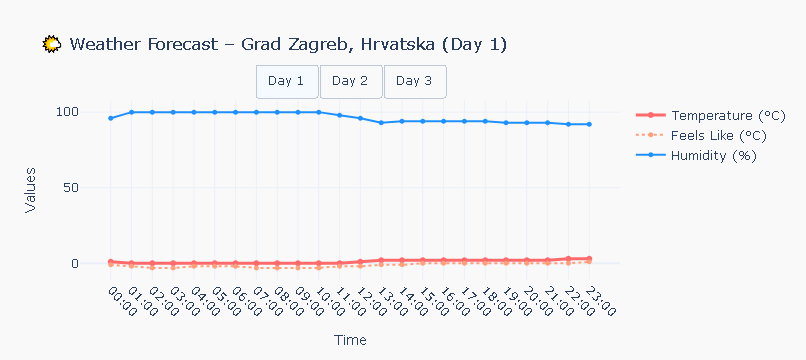

In [20]:
# -----------------------------------------
# 📊 Static Weather Plot (Plotly)
# -----------------------------------------

# Create an empty Plotly figure that will contain all traces
fig_static_buttons = go.Figure()

# Number of metrics per day (Temperature, Feels Like, Humidity)
traces_per_day = 3

# Add traces for each day
for i, day_name in enumerate(day_names):

    df_day = dfs_per_day[day_name]

    # Custom hover text for each point
    hover_text = [
            (f"Time: {t}<br>"
            f"Temp: {temp}°C<br>"
            f"Feels: {feels}°C<br>"
            f"Humidity: {hum}%<br>"
            f"Wind: {wind} m/s<br>"
            f"Precip: {prec} mm<br>"
            f"{emoji}")
        for t, temp, feels, hum, wind, prec, emoji in zip(
            df_day["Time"],
            df_day["Temperature (°C)"],
            df_day["Feels Like (°C)"],
            df_day["Humidity (%)"],
            df_day["Wind (m/s)"],
            df_day["Precipitation (mm)"],
            df_day["Weather Emoji"])]

    # Temperature trace
    fig_static_buttons.add_trace(
        go.Scatter(
            x = df_day["Time"],  # X‑axis: time of day
            y = df_day["Temperature (°C)"],  # Y‑axis: temperature in °C
            mode = "lines+markers",  # Show both lines and data points
            name = "Temperature (°C)",
            line = dict(color = "#FF6B6B", width = 3),  # Styling: red line, thick
            marker = dict(size = 6, color = "#FF6B6B"),  # Styling: matching red markers
            hoverinfo = "text",  # Use custom hover text instead of default
            hovertext = hover_text,  # Detailed info (time, feels‑like, humidity, etc.)
            visible = (i == 0)))  # Only show this day's data initially (hide others)

    # Feels Like trace
    fig_static_buttons.add_trace(
        go.Scatter(
            x = df_day["Time"],
            y = df_day["Feels Like (°C)"],
            mode = "lines+markers",
            name = "Feels Like (°C)",
            line = dict(color = "#FFA07A", width = 2, dash = "dot"),
            marker = dict(size = 5, color = "#FFA07A"),
            hoverinfo = "text",
            hovertext = hover_text,
            visible = (i == 0)))

    # Humidity trace
    fig_static_buttons.add_trace(
        go.Scatter(
            x = df_day["Time"],
            y = df_day["Humidity (%)"],
            mode = "lines+markers",
            name = "Humidity (%)",
            line = dict(color = "#1E90FF", width = 2),
            marker = dict(size = 5, color = "#1E90FF"),
            hoverinfo = "text",
            hovertext = hover_text,
            visible = (i == 0)))

# ------------------------------
# Buttons to toggle between days
# ------------------------------
buttons = []

for i, day_name in enumerate(day_names):

    # All traces start hidden
    visible = [False] * (len(day_names) * traces_per_day)

    # Show the 3 traces for the selected day
    for j in range(traces_per_day):
        visible[i * traces_per_day + j] = True

    buttons.append(
    dict(label = day_name,           # Button text
         method = "update",          # Action on click
         args = [
            {"visible" : visible}, # Which traces to show
            {"title" : f"🌤️ Weather Forecast – {city_clean}, {country_clean} ({day_name})"}  # Update title
        ]))

# ------------------------------
# Layout configuration
# ------------------------------
fig_static_buttons.update_layout(
    updatemenus = [
        dict(type = "buttons",       # Menu type is buttons
            direction = "right",    # Buttons arranged horizontally
            buttons = buttons,      # List of buttons defined earlier
            x = 0.5,                # X position of menu (centered)
            xanchor = "center",     # Anchor at center horizontally
            y = 1.2,                # Y position above plot
            yanchor = "top")        # Anchor at top vertically
    ],
    
    xaxis_title = "Time",         # X-axis label
    yaxis_title = "Values",       # Y-axis label
    template = "plotly_white",    # Plotly theme
    xaxis = dict(tickangle = 45), # Rotate X-axis labels
    legend = dict(font = dict(size = 13)), # Legend font size
    plot_bgcolor = "#f9f9f9",     # Background color inside plot
    paper_bgcolor = "#f9f9f9",    # Background color outside plot
    title = f"🌤️ Weather Forecast – {city_clean}, {country_clean} ({day_names[0]})" # Initial plot title
)

# Show the interactive chart
fig_static_buttons.show()

## 🌤️ Interactive Plotly Graph with Day Buttons

This section creates a **fully interactive Plotly chart** for weather forecast:

1. **Traces included**:
   - Temperature (°C)
   - Feels Like (°C)
   - Humidity (%)
2. **Animation**:
   - Each frame reveals all points up to the current timestamp.
   - Play/Pause buttons let the user control the animation.
   - Slider allows manual selection of any time point.
4. **Hover information** shows detailed weather data for each time point:
   - Temperature and Feels Like
   - Humidity
   - Wind speed
   - Precipitation
   - Weather emoji
5. Chart styling includes **custom colors, line styles, markers**, and hover tooltips to enhance readability.
6. The graph can be **exported as HTML** for sharing or embedding in web pages.


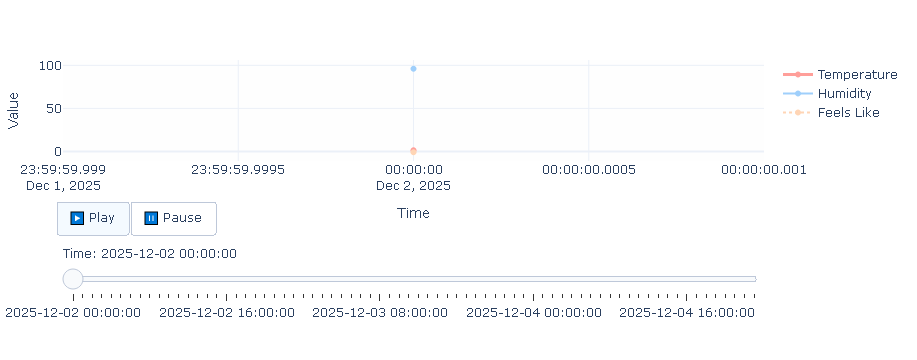

In [22]:
# -----------------------------------------
# 📊 Animated Weather Plot (Plotly)
# -----------------------------------------

def create_animated_plot(df):
    """
    Create an animated Plotly line chart that reveals Temperature,
    Humidity, and Feels Like values over time, one point at a time.
    Includes Play/Pause buttons and a slider below the chart.
    """

    # Sort data by time to ensure proper animation order
    df_sorted = df.sort_values("Time").reset_index(drop = True)

    # Colors for each metric
    color_temp = "#FF9F9A"
    color_hum = "#9FCFFB"
    color_feels = "#FFD5B5"

    frames = []

    # -----------------------------------------
    # Build animation frames
    # Each frame reveals all points up to the current time
    # -----------------------------------------
    for i, row in df_sorted.iterrows():

        # Hover text for visible points in this frame
        hover_text = [
                (f"Time: {t}<br>"
                f"Temp: {temp}°C<br>"
                f"Feels: {feels}°C<br>"
                f"Humidity: {hum}%<br>"
                f"Wind: {wind} m/s<br>"
                f"Precip: {prec} mm<br>"
                f"{emoji}")
        
            for t, temp, feels, hum, wind, prec, emoji in zip(
                df_sorted["Time"][:i+1],
                df_sorted["Temperature (°C)"][:i+1],
                df_sorted["Feels Like (°C)"][:i+1],
                df_sorted["Humidity (%)"][:i+1],
                df_sorted["Wind (m/s)"][:i+1],
                df_sorted["Precipitation (mm)"][:i+1],
                df_sorted["Weather Emoji"][:i+1])]

        # Add Temperature, Humidity, and Feels Like traces for this frame
        frames.append(
            go.Frame(
                data = [
                    go.Scatter(
                        x = df_sorted["Time"][:i+1],
                        y = df_sorted["Temperature (°C)"][:i+1],
                        mode = "lines+markers",
                        name = "Temperature",
                        line = dict(color = color_temp, width = 3),
                        marker = dict(size = 6, color = color_temp, opacity = 0.8),
                        hovertext = hover_text,
                        hoverinfo = "text"),
                    
                    go.Scatter(
                        x = df_sorted["Time"][:i+1],
                        y = df_sorted["Humidity (%)"][:i+1],
                        mode = "lines+markers",
                        name = "Humidity",
                        line = dict(color = color_hum, width = 2),
                        marker = dict(size = 5, color = color_hum, opacity = 0.8),
                        hovertext = hover_text,
                        hoverinfo = "text"),
                    
                    go.Scatter(
                        x = df_sorted["Time"][:i+1],
                        y = df_sorted["Feels Like (°C)"][:i+1],
                        mode = "lines+markers",
                        name = "Feels Like",
                        line = dict(color = color_feels, width = 2, dash = "dot"),
                        marker = dict(size = 5, color = color_feels, opacity = 0.8),
                        hovertext = hover_text,
                        hoverinfo = "text"),
                ],
                name = str(row["Time"])))  # frame label for slider

    # -----------------------------------------
    # Initial traces (first visible point)
    # -----------------------------------------
    initial = [
        go.Scatter(
            x = [df_sorted["Time"].iloc[0]],               # X value: first timestamp
            y = [df_sorted["Temperature (°C)"].iloc[0]],   # Y value: first temperature
            mode = "lines+markers",                        # Show line with markers
            name = "Temperature",                          # Trace name
            line = dict(color = color_temp, width = 3)),    # Line color and thickness
         
        go.Scatter(
            x = [df_sorted["Time"].iloc[0]],
            y = [df_sorted["Humidity (%)"].iloc[0]],
            mode = "lines+markers",
            name = "Humidity",
            line = dict(color = color_hum, width = 2)),
                
        go.Scatter(
            x = [df_sorted["Time"].iloc[0]],
            y = [df_sorted["Feels Like (°C)"].iloc[0]],
            mode = "lines+markers",
            name = "Feels Like",
            line = dict(color = color_feels, width = 2, dash = "dot")),
    ]

    fig = go.Figure(data = initial, frames = frames)

    # -----------------------------------------
    # Slider steps for manually selecting frames
    # -----------------------------------------
    slider_steps = [dict(
            method = "animate",   # Action when slider moves: play animation
            args = [[f.name],     # Frame to show (by name)
                    {"frame": {"duration": 300, "redraw": True}, "mode": "immediate"}],  # Animation settings
            label = f.name)        # Label displayed on the slider
        for f in frames]
    
    sliders = [dict(
        active = 0,                # Initial active step
        steps = slider_steps,      # List of slider steps
        x = 0,                     # X position of slider
        y = -0.8,                  # Y position below plot
        xanchor = "left",          # Anchor left horizontally
        yanchor = "top",           # Anchor top vertically
        len = 1,                   # Length of slider (full width)
        pad = {"t": 0, "b": 30},   # Padding around slider (top, bottom)
        currentvalue = {"prefix": "Time: "})]  # Text showing current value
    
    updatemenus = [dict(
        type = "buttons",           # Menu type: buttons
        buttons = [
            dict(
                label = "▶️ Play",  # Play button label
                method = "animate", # Animate frames
                args = [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]),
            
            dict(
                label = "⏸️ Pause", # Pause button label
                method = "animate", # Stop animation
                args = [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])],
        
        direction = "left",         # Buttons arranged horizontally
        x = -0.01,                  # X position
        y = -0.4,                   # Y position (below slider)
        xanchor = "left",           # Anchor left horizontally
        yanchor = "top",            # Anchor top vertically
        pad = {"t": 0, "b": 20})]     # Padding around buttons (top, bottom)

    # -----------------------------------------
    # Final layout
    # -----------------------------------------
    fig.update_layout(
        sliders = sliders,          # Add slider to figure
        updatemenus = updatemenus,  # Add play/pause buttons
        xaxis_title = "Time",       # X-axis label
        yaxis_title = "Value",      # Y-axis label
        template = "plotly_white",  # Plotly theme
        plot_bgcolor = "#FEFEFE",   # Plot background color
        margin = dict(l = 40, r = 40, t = 60, b = 120))  # Extra space around plot (esp. bottom for slider/buttons)

    return fig

# -----------------------------------------
# Create and display the animated figure
# -----------------------------------------
fig_anim = create_animated_plot(df)
fig_anim.show()

# Export to HTML (optional)
graph_html = fig_anim.to_html(full_html = False)


## 🗺️ Folium Map: Current Temperature

This section creates an **interactive map** showing the current weather at the selected city:

1. The map is **centered on the city coordinates** (`latitude` and `longitude`) with a zoom level of 10.
2. A **marker** displays:
   - City and country name
   - Current temperature (°C)
   - Weather emoji
3. **Hovering or clicking** on the marker shows a tooltip or popup with the weather information.

In [24]:
# -----------------------------------------
# 🌍 Display current weather on a map
# -----------------------------------------

# Select the first row of the forecast dataframe (current weather)
current = df.iloc[0]

# Extract the current temperature and weather emoji
current_temp = current['Temperature (°C)']
current_emoji = current['Weather Emoji']

# Create a Folium map centered at the specified coordinates
m = folium.Map(location = [lat, lon],
                zoom_start = 10,
                tiles = 'CartoDB positron')

# Prepare tooltip / popup text for the marker
tooltip_text = f'{city_clean}, {country_clean}<br>Temperature: {current_temp}°C {current_emoji}'

# Add a marker showing current weather
folium.Marker(location = [lat, lon],
              popup = tooltip_text,
              tooltip = f'{current_temp}°C {current_emoji}',
              icon = folium.Icon(color = 'red', icon = 'cloud')).add_to(m)

# Display the map (works in Jupyter Notebook)
m


## 🗺️ Extra Map Information

This section adds **additional information** about the city to the map:

1. Displays the **city name**.
2. Shows **precise coordinates** (latitude and longitude) with 6 decimal places.
3. This information can be used as a tooltip or marker popup on the Folium map.


In [26]:
# -----------------------------------------
# 🗺️ Extra Map Information
# -----------------------------------------

# Prepare a string with city name and precise coordinates
extra_map_info = f"City: {city_clean}, Coordinates: {lat:.6f}, {lon:.6f}"

# Display the information
print(extra_map_info)


City: Grad Zagreb, Coordinates: 45.813097, 15.977279


## 💾 Export Data & Graph

This section saves the weather forecast data, charts, and map for later use. All files are stored in the `exported_forecast` folder.

1. **CSV file** (`exported_forecast/forecast_3days.csv`) — raw forecast data for further analysis.
2. **Excel file** (`exported_forecast/forecast_3days.xlsx`) — easily viewable and shareable spreadsheet.
3. **Static HTML file** (`exported_forecast/forecast_3days_static.html`) — contains the Plotly chart for the three-day forecast.
4. **Interactive HTML file** (`exported_forecast/forecast_interactive.html`) — contains the full animated Plotly chart for web display or offline viewing.
5. **Map HTML file** (`exported_forecast/weather_map.html`) — contains the saved interactive weather map.
6. A confirmation message is displayed listing all the saved files.


In [28]:
# -----------------------------------------
# 💾 Export Forecast Data and Visuals
# -----------------------------------------

# Folder where all files will be saved
folder = "exported_forecast"
os.makedirs(folder, exist_ok = True)

# ---------- 1️⃣ Save as CSV ----------
csv_file = os.path.join(folder, "forecast_3days.csv")
df.to_csv(csv_file, index = False)

# ---------- 2️⃣ Save as Excel ----------
excel_file = os.path.join(folder, "forecast_3days.xlsx")
df.to_excel(excel_file, index = False)

# ---------- 3️⃣ Save static HTML for three days ----------
static_html_file = os.path.join(folder, "forecast_3days_static.html")
fig_static_buttons.write_html(static_html_file)

# ---------- 4️⃣ Save interactive Plotly HTML ----------
interactive_html_file = os.path.join(folder, "forecast_interactive.html")
fig_anim.write_html(interactive_html_file, include_plotlyjs = 'cdn')

# ---------- 5️⃣ Save the map as an HTML file ----------
map_file = os.path.join(folder, "weather_map.html")
m.save(map_file)

# ---------- 6️⃣ Confirmation message ----------
print("💾 Export complete!")
print(f"✅ CSV file: {csv_file}")
print(f"✅ Excel file: {excel_file}")
print(f"✅ Static HTML: {static_html_file}")
print(f"✅ Interactive HTML: {interactive_html_file}")
print(f"✅ Map HTML: {map_file}")


💾 Export complete!
✅ CSV file: exported_forecast\forecast_3days.csv
✅ Excel file: exported_forecast\forecast_3days.xlsx
✅ Static HTML: exported_forecast\forecast_3days_static.html
✅ Interactive HTML: exported_forecast\forecast_interactive.html
✅ Map HTML: exported_forecast\weather_map.html
